## Importing necessary libraries and dataset

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.tz import gettz
from pandas import Timedelta

In [2]:
df = pd.read_csv('dstest.csv')
print(df.shape)
df.head()

(385165, 13)


,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235


In [3]:
# Displaying the number of fucntions
df['company'].value_counts()

Streamroot TV    370832
Flash Infos       12432
Sports News        1901
Name: company, dtype: int64

In [4]:
# Understanding the peers_count. 
df['peers_count'].value_counts()
df[df['peers_count'] == 20.83]

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
128891,Streamroot TV,VOD,ME1,386556764.0,0.0,0.0,20.83,40,1562465500429,240000.0,0,0,content-14609


#### The first payload is identified after first 2 minutes which is 120000 in milli seconds. This is filtered then along by this value in column of 'sessionduration'
#### The last payload is identified as the payload just before the first payload. 

In [4]:
# This method of creating columns is not optmized process. But it serves the purpose in this case.
df['isFirstPayload'] = ''
df['isLastPayLoad'] = ''
num = len(df)
for i in range(num):
    if i == 0:
        df['isFirstPayload'][i] = True
        df['isLastPayLoad'][i] = False
    elif df['sessionDuration'][i] == 120000:
        df['isFirstPayload'][i] = True
        df['isLastPayLoad'][i-1] = True
    elif i == num:
        df['isFirstPayload'][i] = False
        df['isLastPayLoad'][i] = True
    else:
        df['isFirstPayload'][i] = False
        df['isLastPayLoad'][i-1] = False

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/lib/python3.7/site-packages/ip

#### Adding a column 'readableDate' to that will be the beginning of the 2 minutes window during which the payload was sent.

In [84]:
from datetime import datetime
df['readableDate'] =  ''
df['readableDate'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df['readableDate'] = (df['readableDate'] - timedelta(minutes = 2)).dt.strftime('%H:%M')
df['readableDate'].value_counts()

07:57    1968
07:55    1941
07:56    1908
07:53    1893
07:51    1893
         ... 
02:03     207
02:00     151
02:01     139
01:58      75
01:59      70
Name: readableDate, Length: 360, dtype: int64

#### Changing this again to seconds to make use of seconds. Assumption is that seconds should be 0 for every hour-minute. This can't be achieved through timestamp. So, convert the 'readableDate' again into H:M:S format. Unfortunately since we dont have seconds and date, python automatically starts this from year 1900. But we can take it out date later and display the time

In [85]:
df['readableDate'] = df['readableDate'].apply(lambda x: datetime.strptime(x, '%H:%M'))
df['readableDate'].value_counts()

1900-01-01 07:57:00    1968
1900-01-01 07:55:00    1941
1900-01-01 07:56:00    1908
1900-01-01 07:51:00    1893
1900-01-01 07:53:00    1893
                       ... 
1900-01-01 02:03:00     207
1900-01-01 02:00:00     151
1900-01-01 02:01:00     139
1900-01-01 01:58:00      75
1900-01-01 01:59:00      70
Name: readableDate, Length: 360, dtype: int64

In [76]:
# Filtering the data based on comapny
df_stream_root = df[df['company'] == 'Streamroot TV']
df_Flash_Infos = df[df['company'] == 'Flash Infos']
df_Sports_News = df[df['company'] == 'Sports News']

In [20]:
df_Sports_News['live'].value_counts()

Live    1727
VOD      174
Name: live, dtype: int64

### Question - 1 Metric to evaluate the company's performance

In [32]:
# THis is a metric which gives a tuple of viewing time in minutes, number of contents, errors. Depending upon the use case - 
# - we can generate another metric. For example, Sports News has lots of live TV. Other mainly stream VOD content. 
# Taking all this into consideration, this is just set as tuple. Not a single value which can define the perforamnce since many factoers play a role in it
def performance_indicator(df):
    contents = len(pd.unique(df['content']))
    errors = df['playbackErrorCount'].sum()
    df_new = df[df['isLastPayLoad'] == True]
    total_duration = (df_new['sessionDuration'].sum())/60000
    count = len(df_new)
    view_time = total_duration/count
    return (view_time, contents, errors)

In [33]:
print('The performance of Stream Root TV is {}'.format(performance_indicator(df_stream_root)))

The performance of Stream Root TV is (37.04052628935871, 16898, 0)


In [34]:
print('The performance of Flash Infos is {}'.format(performance_indicator(df_Flash_Infos)))

The performance of Flash Infos is (30.675776397515527, 379, 4)


In [35]:
print('The performance of Sports News is {}'.format(performance_indicator(df_Sports_News)))

The performance of Flash Infos is (33.00869565217391, 21, 11)


#### Overall Stream Root TV performed the best of 3 companies. It got the highest viewing time and no errors with highest number of contents
#### A weighted average of all these  4 different can be made into a single metric. As of now, main metric is the viewing time. This is calculated by summing up all the session durations. This is then converted from milliseconds to minutes. 

## Question 2 - Determine the first payload of the viewer

In [27]:
df['isFirstPayload'].value_counts()

False    364331
True      20834
Name: isFirstPayload, dtype: int64

In [28]:
df['content'].value_counts()

content-15468    2267
content-05333    2091
content-05335    1556
content-05334    1346
content-13697    1221
                 ... 
content-12052       1
content-13938       1
content-03366       1
content-16100       1
content-15765       1
Name: content, Length: 17298, dtype: int64

#### There are 20834 distinct users that are streaming. These users are more than number of unique contents. This indicates there are multiple users streaming the same content.

## Question 3 - Playback error

In [36]:
df['totalPlaybackErrorCount'].value_counts()

0    384912
1       244
3         6
2         3
Name: totalPlaybackErrorCount, dtype: int64

In [37]:
df['playbackErrorCount'].value_counts()

0    385154
1         8
2         2
3         1
Name: playbackErrorCount, dtype: int64

In [39]:
df4 = pd.DataFrame(np.array([['00:00', 0, 0], ['02:00', 0, 0], ['04:00', 1, 1], ['06:00', 0, 1], ['08:00', 1, 2]]),
                   columns=['Time MM:SS', 'playbackErrorCount', 'totalPlaybackErrorCount'])
df4

,Time MM:SS,playbackErrorCount,totalPlaybackErrorCount
0,00:00,0,0
1,02:00,0,0
2,04:00,1,1
3,06:00,0,1
4,08:00,1,2


#### First Payload is recieved at 02:00. And the errors are added up at 2:30, 6:20 resulting in 2 total errors.

### Question - 4

#### Here we take Stream Root TV and content with ID 'content-05335'

In [90]:
# Creating a dataframe by filtering the selected content in StreamRoot TV
df_sel_content = df_stream_root[df_stream_root['content'] == 'content-05335']

In [179]:
# All the Datetime stamps are taken in to a set to see how manu distinct datetime are present 
date_stamps = set()
for i in df_sel_content.index:
    date_stamps.add(df_sel_content['readableDate'][i])
date_stamps = sorted(date_stamps)

In [92]:
date_stamps[-1]

Timestamp('1900-01-01 07:57:00')

In [180]:
# Creating a List of timestamps. This list will give 2 minute timespans which can give us concurrency. 
# This loops breaks down when it access penultimate timestamp. Thus adding the last playload time
lt = []

k = date_stamps[0]
for i in range(len(date_stamps)):
    if i == 0:
        k = date_stamps[i]
        lt.append(k)
    elif lt[i-1] == date_stamps[-2]:
        k2 = lt[i-1] + Timedelta('00:02:00')
        lt.append(k2)
        break
    else:
        k1 = lt[i-1] + Timedelta('00:02:00')
        lt.append(k1)

In [98]:
df_sel_content[(df_sel_content['readableDate'] >= lt[0]) & (df_sel_content['readableDate'] < lt[1])]

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content,isFirstPayload,isLastPayLoad,readableDate,DateTime,readableDate_2
167797,Streamroot TV,VOD,ME1,44236588.0,519632.0,0.0,16.96,40,1562457767702,120000.0,0,0,content-05335,True,False,1900-01-01 02:00:00,1.562458e+09,02:00:47


In [174]:
# Creating a dictionary of timestamp and the concurrency values
sel_content = {}
for i in range(len(lt)-1):
    ds_1 = lt[i]
    ds_2 = lt[i+1]
    df_exm_date = df_sel_content[(df_sel_content['readableDate'] >= ds_1) & (df_sel_content['readableDate'] < ds_2)]
    val = len(df_exm_date)
    sel_content[ds_1] = val

In [175]:
# Putting timestamps and concurrency values in 2 different lists
payload_start_time = []
concurrency_value = []
for time, val in sel_content.items():                                 
    payload_start_time.append(time)
    concurrency_value.append(val)

In [176]:
# THis function strips out the unecessary date of the content we selected
def strip_date(timestamp_list):
    ls = []
    for i in timestamp_list:
        ts = str(i).strip('1900-01-01')
        ts = ts[:-1]
        ls.append(ts)
    return ls

In [177]:
payload_start_time = strip_date(payload_start_time)

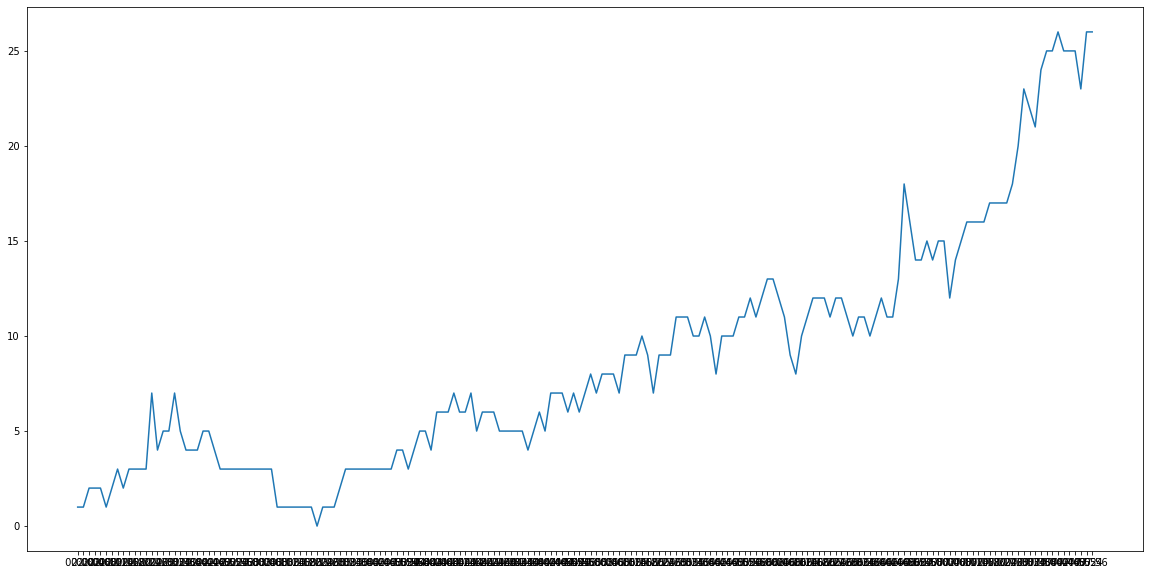

In [178]:
# The x-axis ticks could be better. 
plt.figure(figsize=(20, 10))
plt.plot(payload_start_time, concurrency_value)
plt.show()

#### 4.3 Average Performance when concurrency is less than 10

In [194]:
new_dict = dict((k, v) for k, v in sel_content.items() if v < 10)
keys = [k for k, v in new_dict.items()]

In [205]:
keys[0] 

Timestamp('1900-01-01 02:00:00')

In [206]:
# Creating a new dataframe which will append the payloads for 2 minute span where the concurrency is less than 10
df_conc_10 = pd.DataFrame()
for i in range(len(keys)-1):
    ds_1 = keys[i]
    ds_2 = ds_1 + Timedelta('00:02:00')  
    df_exm_date = df_sel_content[(df_sel_content['readableDate'] >= ds_1) & (df_sel_content['readableDate'] < ds_2)]
    df_conc_10 = df_conc_10.append(df_exm_date)

In [207]:
val_10 = performance_indicator(df_conc_10)
print('The average performance when concurrency is less than 10 is {}'.format(val_10))

The average performance when concurrency is less than 10 is (27.833333333333332, 1, 0)


In [210]:
val_total = performance_indicator(df_sel_content)
print('The performance content-05335 is {}'.format(val_total))

The performance content-05335 is (50.20338983050848, 1, 0)


#### We can see a difference in the performance values. The total performance value for the whole content is 50.2 while the average performance when concurrency less than 10 is 27.8

#### 4.4 Starting from which concurrency can we say there is a 75% chance that the performance on a content is higher than 80%?

#### This question can be answered by graphs or plots. Let's plot a graph between concurrency and time. We need to identify the point of maximum concurrency for a selected time period. This should be performed for all the contents which are required. 
#### Then Maximum 80% value of concurrency should be identified. SImilarly Minimim 80 % of the content should be identified. The concurrency interval is set between [min_concurrency, max_concurrency]. This interval can be break down into 4 parts. The concurrency value where the 3rd sub interval ends is the end value. After this we have 75% chance that performance on a content is higher than 80%.  This process can be applied when there are many contents. And also here is a limitation that chance is not defined. Chance can be based on many factors. 
#### We shall take the above graph plotted. The maximum concurrency value is 26 and 80% of it is 20.8. To identify the 75% chance if obtaining this value, we need a basis to apply it.